# Using Sequence Networks (RNN) for synthetic Time Series 

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Generating Synthetic Data

In [2]:
def plot_series(time, series, format='-', start=00, end = None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Series")
  plt.grid(True)

def trend(time, slope=0):
  return time*slope

def seasonal_pattern(season_time):
  return np.where(season_time < 0.4,
                  np.cos(season_time*2*np.pi),
                  1/np.exp(3*season_time))
  
def seasonality(time, period, amplitude=1, phase=0):
  season_time = ((time + phase)%period)/period
  return amplitude*seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
  rnd= np.random.RandomState(seed)
  return rnd.randn(len(time))*noise_level


In [3]:
time = np.arange(4*365+1, dtype='float32')
baseline = 10
series = trend(time, slope=0.1)
amplitude = 40
slope = 0.05
noise_level = 5

In [4]:
series = baseline + trend(time, slope)+ seasonality(time, 365, amplitude)
# updating it with Noise
series+=series+noise(time, noise_level, 42)

### Splitting the data in Training and Testing Set

In [5]:
split_time = 1000
train_time = time[:split_time]
x_train = series[:split_time]
valid_time = time[split_time:]
x_valid = series[split_time:]

In [6]:
window_size = 20
batch_size = 32
shuffle_batch_size = 1000

### Preparing a Tensorflow Dataset

In [14]:
def window_dataset(series, window_size, batch_size ,shuffle_batch_size):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
  dataset = dataset.shuffle(shuffle_batch_size).map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

## Creating the RNN model

In [19]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = window_dataset(x_train, window_size, batch_size, shuffle_batch_size)

model =tf.keras.models.Sequential([
                                   tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
                                   tf.keras.layers.SimpleRNN(40, return_sequences=True),
                                   tf.keras.layers.SimpleRNN(40),
                                   tf.keras.layers.Dense(1),
                                   tf.keras.layers.Lambda(lambda x: x*100.0)
])

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8*10**(epoch/20)
)
model.compile(loss = tf.keras.losses.Huber(), optimizer= tf.keras.optimizers.SGD(lr = 1e-8,momentum = 0.9))
history = model.fit(train_set, epochs = 100, callbacks = [lr_scheduler])


Epoch 1/100
31/31 [==============================] - 0s 8ms/step - loss: 160.7970
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 142.8915
Epoch 3/100
31/31 [==============================] - 0s 7ms/step - loss: 121.0793
Epoch 4/100
31/31 [==============================] - 0s 7ms/step - loss: 104.4950
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 91.8713
Epoch 6/100
31/31 [==============================] - 0s 7ms/step - loss: 81.2809
Epoch 7/100
31/31 [==============================] - 0s 7ms/step - loss: 71.7825
Epoch 8/100
31/31 [==============================] - 0s 7ms/step - loss: 62.6942
Epoch 9/100
31/31 [==============================] - 0s 7ms/step - loss: 53.9630
Epoch 10/100
31/31 [==============================] - 0s 7ms/step - loss: 46.5602
Epoch 11/100
31/31 [==============================] - 0s 6ms/step - loss: 41.1536
Epoch 12/100
31/31 [==============================] - 0s 7ms/step - loss: 36.1737
Epoch 13/100
31/31 [=

(1e-08, 0.0001, 0.0, 30.0)

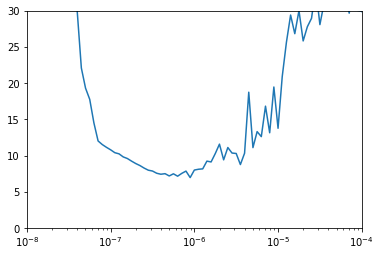

In [25]:
plt.semilogx( history.history['lr'],history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])

In [26]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = window_dataset(x_train, window_size, batch_size, shuffle_batch_size)

model =tf.keras.models.Sequential([
                                   tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
                                   tf.keras.layers.SimpleRNN(40, return_sequences=True),
                                   tf.keras.layers.SimpleRNN(40),
                                   tf.keras.layers.Dense(1),
                                   tf.keras.layers.Lambda(lambda x: x*100.0)
])

model.compile(loss = tf.keras.losses.Huber(), optimizer= tf.keras.optimizers.SGD(lr = 1e-6,momentum = 0.9), metrics = ['mae'])
history = model.fit(train_set, epochs = 500)

Epoch 1/500
31/31 [==============================] - 0s 7ms/step - loss: 55.2154 - mae: 55.7137
Epoch 2/500
31/31 [==============================] - 0s 7ms/step - loss: 16.8426 - mae: 17.3361
Epoch 3/500
31/31 [==============================] - 0s 7ms/step - loss: 9.6096 - mae: 10.0931
Epoch 4/500
31/31 [==============================] - 0s 7ms/step - loss: 8.1411 - mae: 8.6216
Epoch 5/500
31/31 [==============================] - 0s 7ms/step - loss: 8.5930 - mae: 9.0778
Epoch 6/500
31/31 [==============================] - 0s 7ms/step - loss: 8.7186 - mae: 9.2055
Epoch 7/500
31/31 [==============================] - 0s 7ms/step - loss: 8.0750 - mae: 8.5612
Epoch 8/500
31/31 [==============================] - 0s 7ms/step - loss: 7.8145 - mae: 8.2961
Epoch 9/500
31/31 [==============================] - 0s 7ms/step - loss: 8.1273 - mae: 8.6140
Epoch 10/500
31/31 [==============================] - 0s 7ms/step - loss: 9.2265 - mae: 9.7143
Epoch 11/500
31/31 [==============================] - 

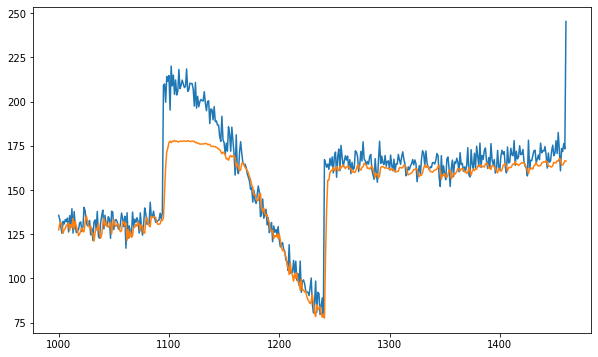

In [27]:
forecast = []

for time in range(len(series)- window_size):
  forecast.append(model.predict(series[time: time+window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0 ,0]

plt.figure(figsize = (10,6))
plt.plot(valid_time, x_valid)
plt.plot(valid_time, results)


In [28]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

8.501999

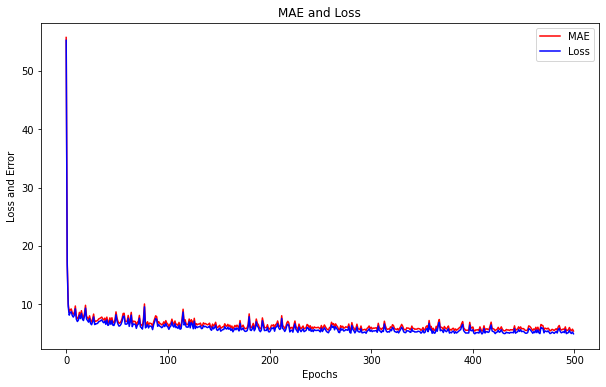

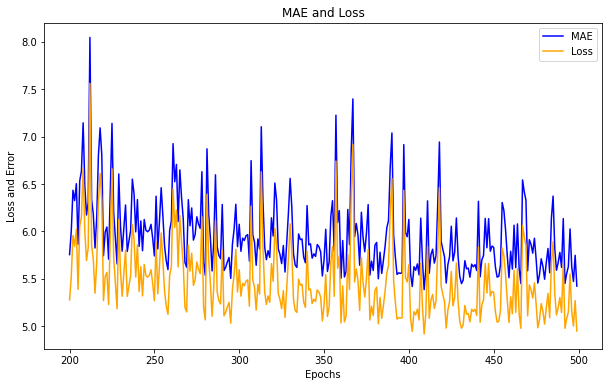

In [44]:
import matplotlib.image as mpimg
mae = history.history['mae']
loss = history.history['loss']
epochs = len(loss)
#----------------------------------------
# Visualizing the mae and loss
# ---------------------------------------
plt.figure(figsize = (10,6))

plt.plot(range(epochs), mae, 'r')
plt.plot(range(epochs), loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss and Error")
plt.legend(["MAE", "Loss"])

#----------------------------------------
# Visualizing the mae and loss
# ---------------------------------------
plt.figure(figsize = (10,6))


plt.plot(range(200,epochs), mae[200:],'b')
plt.plot(range(200,epochs), loss[200:],'orange')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss and Error")
plt.legend(["MAE", "Loss"])